In [1]:
# Mount Google Drive
#from google.colab import drive
#drive.mount('/content/gdrive')

#  from google.colab import files
#  files.upload()

# !rm -r ~/.Kaggle

# !mkdir ~/.kaggle

# !mv ./kaggle.json ~/.kaggle/

# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d salader/dogs-vs-cats

# !cp /content/dogs-vs-cats.zip /content/gdrive/MyDrive/dog_cat/dogs-vs-cats.zip


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [3]:
!kaggle datasets download -d salader/dogs-vs-cats

100% 1.06G/1.06G [00:10<00:00, 130MB/s]
100% 1.06G/1.06G [00:10<00:00, 106MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.models import Sequential
import os
import random
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

In [6]:
# Generators
train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/train',
    labels='inferred',
    label_mode='int',
    batch_size=64,
    image_size=(256, 256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory='/content/test',
    labels='inferred',
    label_mode='int',
    batch_size=64,
    image_size=(256, 256)
)

# Print class names and class indices
class_names = train_ds.class_names
print("Class Names:", class_names)

# If you still want class indices, you can use the class_names list
class_indices = {class_name: index for index, class_name in enumerate(class_names)}
print("Class Indices:", class_indices)


Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Class Names: ['cats', 'dogs']
Class Indices: {'cats': 0, 'dogs': 1}


In [7]:
# Initialize counters
total_cat_images_train = 0
total_dog_images_train = 0
total_cat_images_validation = 0
total_dog_images_validation = 0

In [8]:
# Iterate through training & validation dataset
for _, labels in train_ds:
    total_cat_images_train += sum(labels.numpy() == class_indices['cats'])
    total_dog_images_train += sum(labels.numpy() == class_indices['dogs'])

In [9]:
for _, labels in validation_ds:
    total_cat_images_validation += sum(labels.numpy() == class_indices['cats'])
    total_dog_images_validation += sum(labels.numpy() == class_indices['dogs'])

In [10]:
print("Total Cat Images in Training Dataset:", total_cat_images_train)
print("Total Dog Images in Training Dataset:", total_dog_images_train)
print("Total Cat Images in Validation Dataset:", total_cat_images_validation)
print("Total Dog Images in Validation Dataset:", total_dog_images_validation)

Total Cat Images in Training Dataset: 10000
Total Dog Images in Training Dataset: 10000
Total Cat Images in Validation Dataset: 2500
Total Dog Images in Validation Dataset: 2500


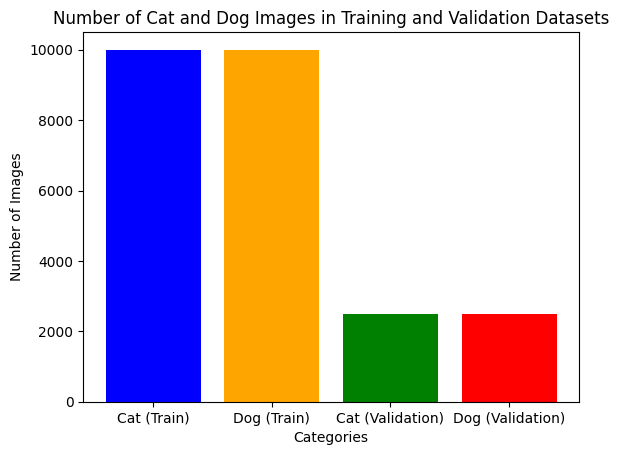

In [11]:
categories = ['Cat (Train)', 'Dog (Train)', 'Cat (Validation)', 'Dog (Validation)']
counts = [total_cat_images_train, total_dog_images_train, total_cat_images_validation, total_dog_images_validation]

plt.bar(categories, counts, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Number of Cat and Dog Images in Training and Validation Datasets')
plt.show()


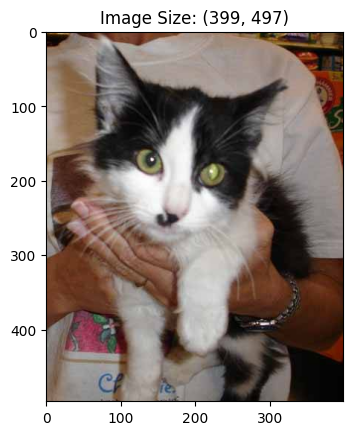

In [12]:
directory = '/content/train/cats'
filenames = os.listdir(directory)

sample = random.choice(filenames)
image_path = os.path.join(directory, sample)
image = load_img(image_path)

plt.imshow(image)
plt.title(f"Image Size: {image.size}")
plt.show()


In [13]:
#normalize
def process(image,label):
  image = tf.cast(image/255.0, tf.float32)
  return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

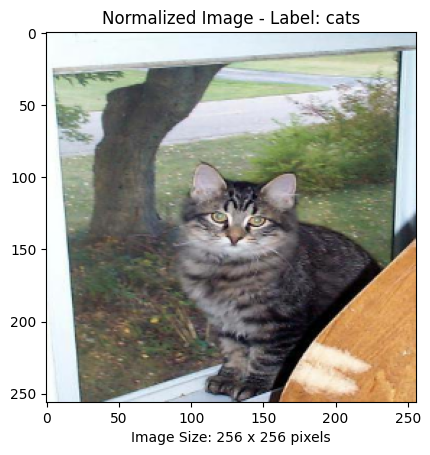

In [14]:
# Display a normalized image
def display_normalized_image(dataset):
    for images, labels in dataset.take(1):
        normalized_image = images[0].numpy()
        label = class_names[labels[0]]

        plt.imshow(normalized_image)
        plt.title(f"Normalized Image - Label: {label}")

        plt.xlabel(f"Image Size: {normalized_image.shape[0]} x {normalized_image.shape[1]} pixels")
        plt.show()

display_normalized_image(validation_ds)


In [15]:
# Create CNN model
model = Sequential()

# Input Layer
model.add(Conv2D(10, kernel_size=(3, 3), padding='valid', activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

# Convolutional Layers with Max Pooling
model.add(Conv2D(20, kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

model.add(Conv2D(40, kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

model.add(Conv2D(80, kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

# Flatten Layer
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(80, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))

# Output Layer
model.add(Dense(1, activation='sigmoid'))  # Binary classification, so use sigmoid in the output layer


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 10)      280       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 10)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 20)      1820      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 20)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 40)        7240      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 40)        0

In [17]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [18]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
313/313 [==============================] - 59s 162ms/step - loss: 0.6718 - accuracy: 0.5743 - val_loss: 0.6506 - val_accuracy: 0.6040
Epoch 2/10
313/313 [==============================] - 51s 160ms/step - loss: 0.5938 - accuracy: 0.6819 - val_loss: 0.5773 - val_accuracy: 0.6902
Epoch 3/10
313/313 [==============================] - 52s 165ms/step - loss: 0.5419 - accuracy: 0.7241 - val_loss: 0.5342 - val_accuracy: 0.7312
Epoch 4/10
313/313 [==============================] - 51s 160ms/step - loss: 0.5052 - accuracy: 0.7546 - val_loss: 0.4892 - val_accuracy: 0.7664
Epoch 5/10
313/313 [==============================] - 48s 152ms/step - loss: 0.4807 - accuracy: 0.7682 - val_loss: 0.4687 - val_accuracy: 0.7840
Epoch 6/10
313/313 [==============================] - 51s 162ms/step - loss: 0.4566 - accuracy: 0.7872 - val_loss: 0.4626 - val_accuracy: 0.7800
Epoch 7/10
313/313 [==============================] - 45s 141ms/step - loss: 0.4398 - accuracy: 0.7968 - val_loss: 0.4600 - val_ac

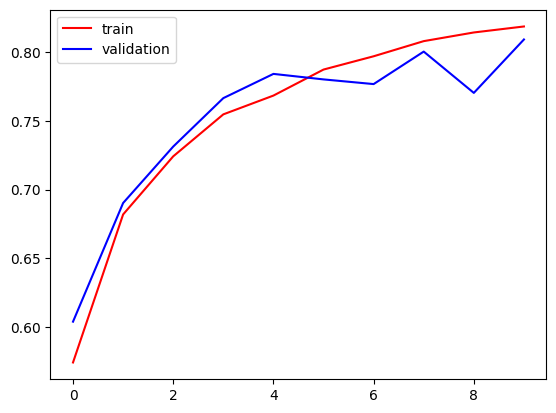

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color = 'red', label='train')
plt.plot(history.history['val_accuracy'],color = 'blue', label='validation')
plt.legend()
plt.show()

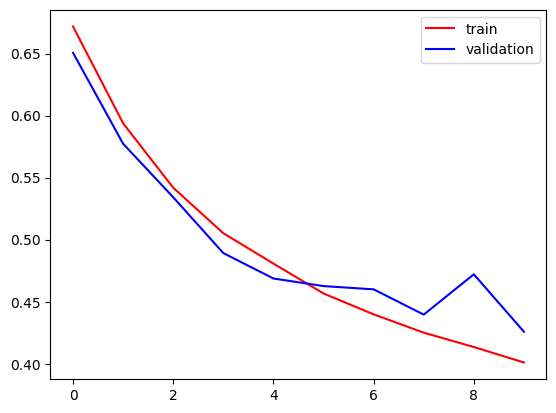

In [20]:
plt.plot(history.history['loss'],color = 'red', label='train')
plt.plot(history.history['val_loss'],color = 'blue', label='validation')
plt.legend()
plt.show()

In [21]:
# Save the trained model
model.save('dog_cat_classifier.h5')
print("Model saved successfully.")

Model saved successfully.


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved model
loaded_model = keras.models.load_model('dog_cat_classifier.h5')

1/1 [==============================] - 0s 387ms/step
Raw Prediction Result: [[0.8695417]]
Prediction: Dog


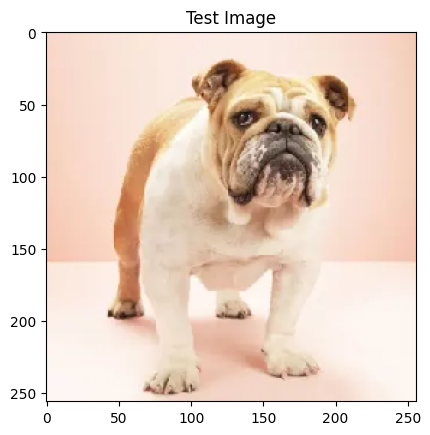

In [24]:
# Load and preprocess a new test image
new_image_path ="/content/dd.webp" # Replace with the path to your test image
img = image.load_img(new_image_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add an extra dimension to match the model's expected input shape
img_array /= 255.0  # Normalize the pixel values

# Make a prediction
prediction = loaded_model.predict(img_array)

# Print the raw prediction result
print("Raw Prediction Result:", prediction)

# Print the refined prediction result
if prediction[0][0] >= 0.5:
    print("Prediction: Dog")
else:
    print("Prediction: Cat")

# Display the test image
plt.imshow(img)
plt.title("Test Image")
plt.show()

In [25]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [26]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [27]:
# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

In [28]:
# Build a new model on top of the pre-trained model
vgg = Sequential()
vgg.add(base_model)
vgg.add(Flatten())

# Add a new Dense layer with an appropriate number of units
vgg.add(Dense(512, kernel_initializer='he_normal', activation='relu'))
vgg.add(Dropout(0.2))
vgg.add(Dense(256, kernel_initializer='he_normal', activation='relu'))
vgg.add(Dropout(0.2))
vgg.add(Dense(128, kernel_initializer='he_normal', activation='relu'))
vgg.add(Dropout(0.2))
vgg.add(Dense(64, kernel_initializer='he_normal', activation='relu'))
vgg.add(Dropout(0.2))
vgg.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid'))

In [29]:
base_model.trainable = False

In [30]:
batch_size = 64

train_dg = ImageDataGenerator(rescale = 1./255,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             horizontal_flip = True)
test_dg = ImageDataGenerator(rescale = 1./255)

train_gen = train_dg.flow_from_directory('/content/dogs_vs_cats/train',
                                        target_size = (150,150),
                                        batch_size = batch_size,
                                        class_mode = "binary")

test_gen = test_dg.flow_from_directory('/content/dogs_vs_cats/test',
                                        target_size = (150,150),
                                        batch_size = batch_size,
                                        class_mode = "binary")

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [31]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
vgg.compile(optimizer= optimizer, loss = "binary_crossentropy", metrics = ["accuracy"])

In [ ]:
history2 = vgg.fit(train_gen,
                   epochs=10,
                   validation_data=test_gen)

Epoch 1/10
313/313 [==============================] - 168s 493ms/step - loss: 0.3857 - accuracy: 0.8223 - val_loss: 0.2351 - val_accuracy: 0.8996
Epoch 2/10
313/313 [==============================] - 149s 475ms/step - loss: 0.2782 - accuracy: 0.8830 - val_loss: 0.2116 - val_accuracy: 0.9102
Epoch 3/10
313/313 [==============================] - 150s 480ms/step - loss: 0.2522 - accuracy: 0.8939 - val_loss: 0.2046 - val_accuracy: 0.9100
Epoch 4/10
313/313 [==============================] - 148s 472ms/step - loss: 0.2377 - accuracy: 0.8988 - val_loss: 0.2041 - val_accuracy: 0.9124
Epoch 5/10
313/313 [==============================] - 149s 475ms/step - loss: 0.2238 - accuracy: 0.9060 - val_loss: 0.2128 - val_accuracy: 0.9076
Epoch 6/10
313/313 [==============================] - 149s 474ms/step - loss: 0.2139 - accuracy: 0.9108 - val_loss: 0.1998 - val_accuracy: 0.9138
Epoch 7/10
313/313 [==============================] - 149s 475ms/step - loss: 0.2113 - accuracy: 0.9093 - val_loss: 0.2022 -

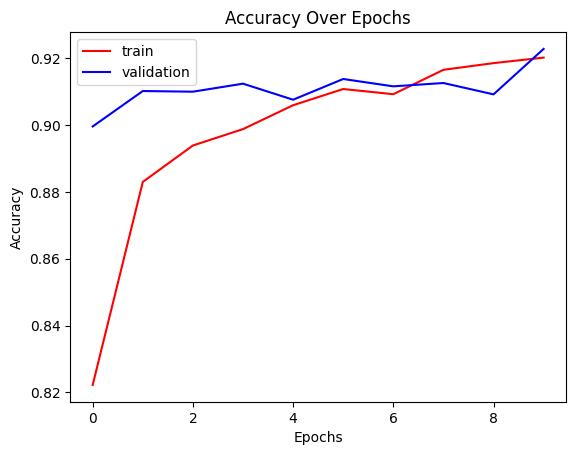

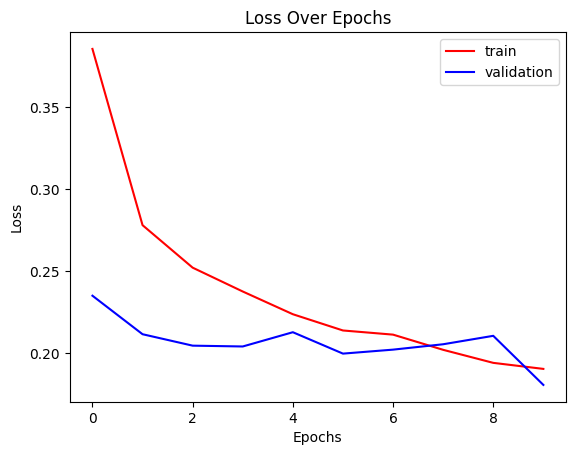

In [35]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history2.history['accuracy'], color='red', label='train')
plt.plot(history2.history['val_accuracy'], color='blue', label='validation')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history2.history['loss'], color='red', label='train')
plt.plot(history2.history['val_loss'], color='blue', label='validation')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 [==============================] - 0s 20ms/step
Raw Prediction: [[1.]]
It's a dog!


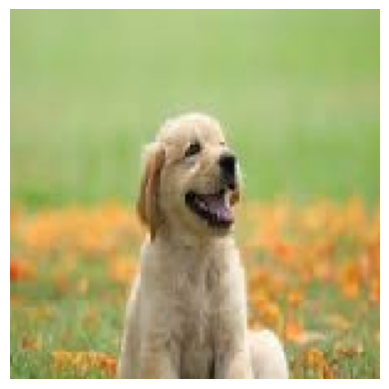

In [41]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load and preprocess a new test image
test_image_path = '/content/d.jpg'
img = image.load_img(test_image_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match batch size

# Make predictions
prediction = vgg.predict(img_array)

# Print the raw prediction result
print("Raw Prediction:", prediction)

# Print the result
if prediction < 0.5:
    print("It's a cat!")
else:
    print("It's a dog!")

# Display the test image
plt.imshow(img)
plt.axis('off')
plt.show()


In [42]:
import pickle
from keras.models import load_model

with open('trained_model.pickle', 'wb') as f:
    pickle.dump(vgg, f)

vgg.save('trained_model.h5')